# Paired integration tutorial

In this notebook we showcase basic Multigrate functionality and integrate a CITE-seq dataset to obtain a joint gene expression and protein abundance representation in a latent space. We use publically available dataset from NeurIPS 2021 workshop https://openproblems.bio/neurips_2021/.

The preprocessed data can be downloaded from https://drive.google.com/drive/folders/1SJeo1OYM__h8vB6dXzGWC8FcLV5fUmgZ?usp=sharing.

In [2]:
import numpy as np
import scanpy as sc
import multigrate as mtg
import scib
from pathlib import Path
import warnings
import anndata
from sklearn.metrics import adjusted_rand_score
import pandas as pd
from muon import prot as pt
warnings.filterwarnings('ignore')

Global seed set to 0
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/ilangold/Projects/Theis/multigrate/venv/lib/python3.9/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


In [5]:
#################################################################
### CHANGE THESE PARAMETERS TO WORK ON REAL DATA OR TEST DATA ###
#################################################################
cite_batch_key = "COMBAT_participant_timepoint_ID"  # Used in various places
cytof_batch_key = "COMBAT_ID_Time"  # Used in various places
batch_key = "COMBAT_participant_timepoint_ID"  # a shared id
use_curated_hvg = True  # Whether or not to use the curated HVG all_HVG_by_ct.tsv
correlation_removal_mode = "low"
correlation_removal_percentage = 80
# Comment in/out which configuration you wish to use.

# TESTING:
# models_path_str = "../models"
# models_path = Path(models_path_str)
# models_path.mkdir(parents=True, exist_ok=True)
# data_path_str = "../../../../scfglue/tests/fixtures"
# data_path = Path(data_path_str)
# data_path.mkdir(parents=True, exist_ok=True)
# adata_cite = anndata.read_h5ad(str(data_path / 'cite-seq.h5ad'))
# adata_cytof = anndata.read_h5ad(str(data_path / 'cytof.h5ad'))
# adata_cytof.obs[batch_key] = adata_cytof.obs[cytof_batch_key]  # For shared batches
# n_comps = 20  # Used for PCA calculation, lower than the number of proteins presetn
# scglue_kwargs = {"max_epochs": 50}  # Limit the number of epochs
# shared_batches = True  # should we only use overlapping batches for real?
# remove_low_count_batches = False
# file_suffix = ""
# use_subset = False
# hvg_list_path = "../../../../scfglue/notebooks/all_HVG_by_ct.tsv"

# TRUE RUN:
models_path_str = "/n/scratch3/users/i/ig62/models/multigrate/subset_model/"
data_path_str = "/n/scratch3/users/i/ig62/data/"
file_suffix = "no_integration"
hvg_list_path = "../../../../scfglue/notebooks/all_HVG_by_ct.tsv"
n_comps = 100
use_subset = True

scglue_kwargs = {"max_epochs": -1}  # Allow scGLUE to determine epochs
shared_batches = True  # should we only use overlapping batches?
remove_low_count_batches = False  # Need this for large datasets with low cell-count batches if you use the standard HVG pipeline (not the included file as filter): https://github.com/scverse/scanpy/issues/1504

In [6]:
models_path = Path(models_path_str)
models_path.mkdir(parents=True, exist_ok=True)
data_path = Path(data_path_str)

adata_cite = anndata.read_h5ad(str(data_path / 'cite-seq.h5ad'))
adata_cytof = anndata.read_h5ad(str(data_path / 'cytof.h5ad'))
if use_subset:
    # subset the data
    # Only using initial time points
    subset = [
        # Two COVID_SEV
        'S00028-Ja001',
        'S00033-Ja001',
        # Two COVID_MILD
        'S00002-Ja001',
        'S00016-Ja001',
        # Two COVID_CRIT
        'S00050-Ja001',
        'S00054-Ja001',
        # Two Sepsis
        'N00021-Ja001',
        'N00023-Ja001',
        # Two HV
        'H00072-Ha001',
        'H00085-Ha001',
        # No Flu - not present in CYTOF
    ]
    adata_cytof = adata_cytof[adata_cytof.obs[cytof_batch_key].isin(subset), :]
    adata_cite = adata_cite[adata_cite.obs[cite_batch_key].isin(subset), :]

adata_cytof.obs[batch_key] = adata_cytof.obs[cytof_batch_key]  # For shared batches

In [7]:
genes_mask = adata_cite.var['feature_types'] == 'Gene Expression'

In [8]:
rna = adata_cite[:, genes_mask]
rna

View of AnnData object with n_obs × n_vars = 409 × 55
    obs: 'Annotation_cluster_id', 'Annotation_cluster_name', 'Annotation_minor_subset', 'Annotation_major_subset', 'Annotation_cell_type', 'GEX_region', 'QC_ngenes', 'QC_total_UMI', 'QC_pct_mitochondrial', 'QC_scrub_doublet_scores', 'TCR_chain_composition', 'TCR_clone_ID', 'TCR_clone_count', 'TCR_clone_proportion', 'TCR_contains_unproductive', 'TCR_doublet', 'TCR_chain_TRA', 'TCR_v_gene_TRA', 'TCR_d_gene_TRA', 'TCR_j_gene_TRA', 'TCR_c_gene_TRA', 'TCR_productive_TRA', 'TCR_cdr3_TRA', 'TCR_umis_TRA', 'TCR_chain_TRA2', 'TCR_v_gene_TRA2', 'TCR_d_gene_TRA2', 'TCR_j_gene_TRA2', 'TCR_c_gene_TRA2', 'TCR_productive_TRA2', 'TCR_cdr3_TRA2', 'TCR_umis_TRA2', 'TCR_chain_TRB', 'TCR_v_gene_TRB', 'TCR_d_gene_TRB', 'TCR_j_gene_TRB', 'TCR_c_gene_TRB', 'TCR_productive_TRB', 'TCR_chain_TRB2', 'TCR_v_gene_TRB2', 'TCR_d_gene_TRB2', 'TCR_j_gene_TRB2', 'TCR_c_gene_TRB2', 'TCR_productive_TRB2', 'TCR_cdr3_TRB2', 'TCR_umis_TRB2', 'BCR_umis_HC', 'BCR_contig_qc

In [9]:
hvg_list = pd.read_csv(Path(hvg_list_path), sep='\t')['gene_name'].values.tolist()
def filter_genes(adata, **kwargs):
    adata = adata[:, adata.var.index.isin(hvg_list)]
    return adata
rna = filter_genes(rna)
rna

View of AnnData object with n_obs × n_vars = 409 × 36
    obs: 'Annotation_cluster_id', 'Annotation_cluster_name', 'Annotation_minor_subset', 'Annotation_major_subset', 'Annotation_cell_type', 'GEX_region', 'QC_ngenes', 'QC_total_UMI', 'QC_pct_mitochondrial', 'QC_scrub_doublet_scores', 'TCR_chain_composition', 'TCR_clone_ID', 'TCR_clone_count', 'TCR_clone_proportion', 'TCR_contains_unproductive', 'TCR_doublet', 'TCR_chain_TRA', 'TCR_v_gene_TRA', 'TCR_d_gene_TRA', 'TCR_j_gene_TRA', 'TCR_c_gene_TRA', 'TCR_productive_TRA', 'TCR_cdr3_TRA', 'TCR_umis_TRA', 'TCR_chain_TRA2', 'TCR_v_gene_TRA2', 'TCR_d_gene_TRA2', 'TCR_j_gene_TRA2', 'TCR_c_gene_TRA2', 'TCR_productive_TRA2', 'TCR_cdr3_TRA2', 'TCR_umis_TRA2', 'TCR_chain_TRB', 'TCR_v_gene_TRB', 'TCR_d_gene_TRB', 'TCR_j_gene_TRB', 'TCR_c_gene_TRB', 'TCR_productive_TRB', 'TCR_chain_TRB2', 'TCR_v_gene_TRB2', 'TCR_d_gene_TRB2', 'TCR_j_gene_TRB2', 'TCR_c_gene_TRB2', 'TCR_productive_TRB2', 'TCR_cdr3_TRB2', 'TCR_umis_TRB2', 'BCR_umis_HC', 'BCR_contig_qc

In [10]:
adt = adata_cite[:, ~genes_mask]
pt.pp.clr(adt)
adt

View of AnnData object with n_obs × n_vars = 409 × 30
    obs: 'Annotation_cluster_id', 'Annotation_cluster_name', 'Annotation_minor_subset', 'Annotation_major_subset', 'Annotation_cell_type', 'GEX_region', 'QC_ngenes', 'QC_total_UMI', 'QC_pct_mitochondrial', 'QC_scrub_doublet_scores', 'TCR_chain_composition', 'TCR_clone_ID', 'TCR_clone_count', 'TCR_clone_proportion', 'TCR_contains_unproductive', 'TCR_doublet', 'TCR_chain_TRA', 'TCR_v_gene_TRA', 'TCR_d_gene_TRA', 'TCR_j_gene_TRA', 'TCR_c_gene_TRA', 'TCR_productive_TRA', 'TCR_cdr3_TRA', 'TCR_umis_TRA', 'TCR_chain_TRA2', 'TCR_v_gene_TRA2', 'TCR_d_gene_TRA2', 'TCR_j_gene_TRA2', 'TCR_c_gene_TRA2', 'TCR_productive_TRA2', 'TCR_cdr3_TRA2', 'TCR_umis_TRA2', 'TCR_chain_TRB', 'TCR_v_gene_TRB', 'TCR_d_gene_TRB', 'TCR_j_gene_TRB', 'TCR_c_gene_TRB', 'TCR_productive_TRB', 'TCR_chain_TRB2', 'TCR_v_gene_TRB2', 'TCR_d_gene_TRB2', 'TCR_j_gene_TRB2', 'TCR_c_gene_TRB2', 'TCR_productive_TRB2', 'TCR_cdr3_TRB2', 'TCR_umis_TRB2', 'BCR_umis_HC', 'BCR_contig_qc

## Prep the input AnnData object

First, we need to organize anndatas correspoding to different datasets and modalities into 1 anndata object. In this example we have 1 CITE-seq dataset, hence we input 2 anndata objects, 1 for RNA modality, 1 for ADT modality, and specify that they are paired (```groups``` argument).

Notes:
- paired datasets have to have the same .obs_names, i.e. index

A couple of examples on how to initialize the data and the model:
- each sublist in `adatas`, `groups`, `layers` parameters correspond to one modality. If you have multiple objects per modality, append them to the corresponding list. If you have paired and unpaired measurements, the missing data should be registered with `None` (see examples below)
- objects in each sublist *have* to have the same set of features: if you want to integrate multiple RNA objects, we recommend first concatenating full objects and then subsetting to 3000-4000 highly variable genes; for ADT modality, we take the intersection of available proteins (double check the naming conventions, as that can vary a lot from one dataset to another, so `.var_names` can have almost no intersection but if you align the protein names, then there is an overlap)
- one paired CITE-seq experiment:
```
adatas = [[rna], [adt]],
groups = [[0], [0]],
```
- one paired CITE-seq experiment and another RNA dataset:
```
adatas = [[rna_cite, rna], [adt_cite, None]],
groups = [[0, 1], [0, 1]],
layers = [['counts', None], [None, None]]
```
- `layers` parameter specifies which layer the model should take the counts from. If `None`, then defaults to `.X`. The distribution of the input data should be the same within a modality, i.e. either use raw counts for all RNA onjects or all normalized

In [8]:
# check that obs_names are indeed the same
np.sum(rna.obs_names != adt.obs_names)

0

In [18]:
common_proteins = list(set(adt.var_names).intersection(set(adata_cytof.var_names)))
adt_common = adt[:, adt.var.index[adt.var.index.isin(common_proteins)]]
adt_unique = adt[:, adt.var.index[~adt.var.index.isin(common_proteins)]]
cytof_common = adata_cytof[:, adata_cytof.var.index[adata_cytof.var.index.isin(common_proteins)]]
modality_lengths = [rna.shape[1], adt_common.shape[1], adt_unique.shape[1]]
adatas = [[rna.copy(), None], [adt_common.copy(), cytof_common.copy()], [adt_unique.copy(), None]]
groups = [[0, 1], [0, 1], [0, 1]]

adata = mtg.data.organize_multiome_anndatas(
    adatas = adatas,           # a list of anndata objects per modality, RNA-seq always goes first
    groups = groups,               # groups that specify which anndatas are paired
    modality_lengths = modality_lengths # how many features in each modality
)
adata

AnnData object with n_obs × n_vars = 981 × 66
    obs: 'Annotation_cluster_id', 'Annotation_cluster_name', 'Annotation_minor_subset', 'Annotation_major_subset', 'Annotation_cell_type', 'GEX_region', 'QC_ngenes', 'QC_total_UMI', 'QC_pct_mitochondrial', 'QC_scrub_doublet_scores', 'TCR_chain_composition', 'TCR_clone_ID', 'TCR_clone_count', 'TCR_clone_proportion', 'TCR_contains_unproductive', 'TCR_doublet', 'TCR_chain_TRA', 'TCR_v_gene_TRA', 'TCR_d_gene_TRA', 'TCR_j_gene_TRA', 'TCR_c_gene_TRA', 'TCR_productive_TRA', 'TCR_cdr3_TRA', 'TCR_umis_TRA', 'TCR_chain_TRA2', 'TCR_v_gene_TRA2', 'TCR_d_gene_TRA2', 'TCR_j_gene_TRA2', 'TCR_c_gene_TRA2', 'TCR_productive_TRA2', 'TCR_cdr3_TRA2', 'TCR_umis_TRA2', 'TCR_chain_TRB', 'TCR_v_gene_TRB', 'TCR_d_gene_TRB', 'TCR_j_gene_TRB', 'TCR_c_gene_TRB', 'TCR_productive_TRB', 'TCR_chain_TRB2', 'TCR_v_gene_TRB2', 'TCR_d_gene_TRB2', 'TCR_j_gene_TRB2', 'TCR_c_gene_TRB2', 'TCR_productive_TRB2', 'TCR_cdr3_TRB2', 'TCR_umis_TRB2', 'BCR_umis_HC', 'BCR_contig_qc_HC', 'B

From now on, we work with one concatenated anndata object ```adata```.

If using raw counts for scRNA, we need to use NB loss (or ZINB), thus need to calculate `size_factors` first. If using normalized counts and MSE for scRNA, `rna_indices_end` does not need to be specified.

In [10]:
mtg.model.MultiVAE.setup_anndata(
    adata,
    rna_indices_end=rna.shape[1], # how many features in the rna-seq modality
    categorical_covariate_keys=[batch_key]
)

INFO     No batch_key inputted, assuming all cells are same batch                                                  
INFO     No label_key inputted, assuming all cells have same label                                                 
INFO     Using data from adata.X                                                                                   
INFO     Successfully registered anndata object containing 981 cells, 66 vars, 1 batches, 1 labels, and 0 proteins.
         Also registered 1 extra categorical covariates and 1 extra continuous covariates.                         
INFO     Please do not further modify adata until model is trained.                                                


If categorical (e.g. sex) or continious covariates (e.g. age) are available, and you'd like to learn a latent representation disentangled from these covariates, additionally specify in setup_anndata
```
categorical_covariate_keys: ["batch"],
continuous_covariate_keys: ["age"]
```

Here we want to get rid of batch effect, so we specify  `batch` as a categorical covariate.

## Initialize the model

Define the model here. If using raw counts for RNA-seq, use NB loss, if normalized counts, use MSE. For ADT we use CLR-normalized counts and MSE loss.

Usually it is not necessary to specify `integrate_on="batch"` and the model correct for batch effects by learning the latent representation disentangled from the batch. If this fails, then we recommend using `integrate_on` parameter.

We recommend setting `n_layers_encoders` and `n_layers_decoders` to 2 for each modality. Here it's set to 1 to minimize the training time.

In case of the mosaic integration, it might be benefitial to set different weights to different modalities. We recommend first training the model with default equal weights (all equal to `1.0`), then checking the training curves (see below) and then if one of the modalities seem to overpower another (e.g. if one of the loss curves goes down but the other one doesn't) to balance the coefficients accordingly. If there are two modalities `0` and `1` (according to the order in which they were initialized), set the corresponding coeffitients as 
```
loss_coefs = {
   '0': 1.0,
   '1': 0.001
}
```

In [11]:
model = mtg.model.MultiVAE(
    adata, 
    modality_lengths=modality_lengths, # how many features per modality
    losses=['nb', 'mse', 'mse'],         # what losses to use for each modality
#     loss_coefs={
#         'kl': 1e-5,
#     }, # 'integ' coef is only used if integrate_on is used
#     integrate_on=batch_key,
    z_dim=15,
    cond_dim=10,
    dropout=0.2,
    n_layers_encoders=[2, 2, 2],
    n_layers_decoders=[2, 2, 2],
)

## Train the model

Can specify the number of epochs by setting `max_epochs` parameter, default is 500. The default batch size is set to `batch_size = 128`, adjust if needed.

In [12]:
model.train(max_epochs=200)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 200/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:28<00:00,  7.02it/s, loss=109, v_num=1]


Plot losses.

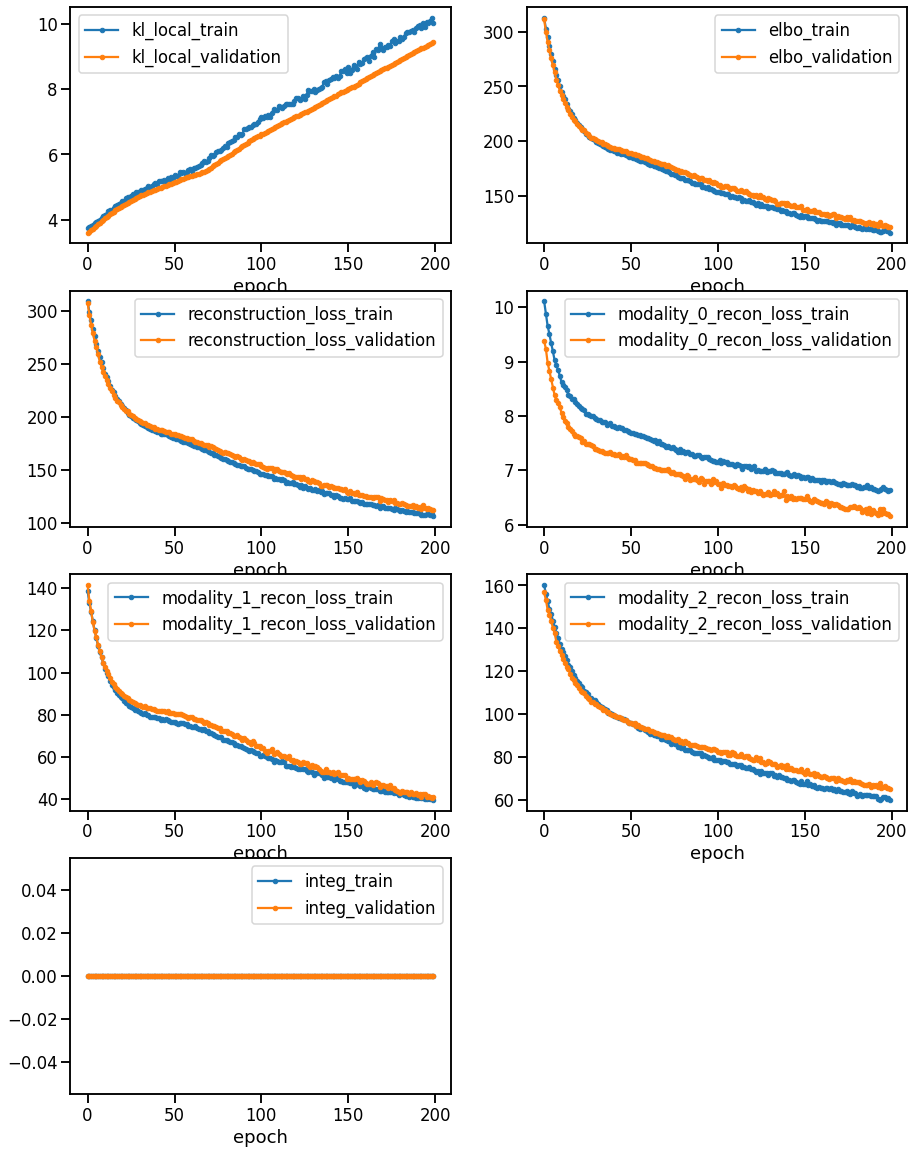

In [13]:
model.plot_losses()

Integration loss is always 0 because we don't explicitely integrate the batches.

## Inference

Get the latent representation.

In [14]:
model.get_latent_representation()
combined = adata
combined.write_h5ad(str(data_path / f'combined_multigrate_{file_suffix}.h5ad'))
combined

AnnData object with n_obs × n_vars = 981 × 66
    obs: 'Annotation_cluster_id', 'Annotation_cluster_name', 'Annotation_minor_subset', 'Annotation_major_subset', 'Annotation_cell_type', 'GEX_region', 'QC_ngenes', 'QC_total_UMI', 'QC_pct_mitochondrial', 'QC_scrub_doublet_scores', 'TCR_chain_composition', 'TCR_clone_ID', 'TCR_clone_count', 'TCR_clone_proportion', 'TCR_contains_unproductive', 'TCR_doublet', 'TCR_chain_TRA', 'TCR_v_gene_TRA', 'TCR_d_gene_TRA', 'TCR_j_gene_TRA', 'TCR_c_gene_TRA', 'TCR_productive_TRA', 'TCR_cdr3_TRA', 'TCR_umis_TRA', 'TCR_chain_TRA2', 'TCR_v_gene_TRA2', 'TCR_d_gene_TRA2', 'TCR_j_gene_TRA2', 'TCR_c_gene_TRA2', 'TCR_productive_TRA2', 'TCR_cdr3_TRA2', 'TCR_umis_TRA2', 'TCR_chain_TRB', 'TCR_v_gene_TRB', 'TCR_d_gene_TRB', 'TCR_j_gene_TRB', 'TCR_c_gene_TRB', 'TCR_productive_TRB', 'TCR_chain_TRB2', 'TCR_v_gene_TRB2', 'TCR_d_gene_TRB2', 'TCR_j_gene_TRB2', 'TCR_c_gene_TRB2', 'TCR_productive_TRB2', 'TCR_cdr3_TRB2', 'TCR_umis_TRB2', 'BCR_umis_HC', 'BCR_contig_qc_HC', 'B

In [15]:
sc.pp.neighbors(combined, n_pcs=15, use_rep="latent", metric="cosine")
sc.tl.umap(combined)
sc.tl.leiden(combined, key_added="leiden_combined", resolution=2, random_state=0)

In [16]:
combined_cite = combined[combined.obs['group'] == 0, :] # adt and rna are combined by default because of the network architecture
adata_cytof = combined[combined.obs['group'] == 1, :]

In [17]:
adjusted_rand_score(adata_cytof.obs['leiden_combined'], adata_cytof.obs['major_cell_type'])

0.2853123505102191

In [18]:
adjusted_rand_score(combined_cite.obs['leiden_combined'], combined_cite.obs['Annotation_major_subset'])

0.4261348062518831

In [19]:
scib.metrics.silhouette(combined_cite, 'Annotation_major_subset',
                        embed='latent'), scib.metrics.silhouette(combined_cite, 'leiden_combined',
                                                                               embed='latent')

(0.471629548817873, 0.5679501295089722)

In [20]:
scib.metrics.isolated_labels(combined_cite, 'Annotation_major_subset',
                             embed='latent',
                             batch_key='COMBAT_participant_timepoint_ID')

isolated labels: no more than 1 batches per label
DN: 0.0392156862745098


0.0392156862745098

In [21]:
scib.metrics.silhouette_batch(combined_cite, 'COMBAT_participant_timepoint_ID', 'Annotation_major_subset',
                              'latent')

mean silhouette per group:         silhouette_score
group                   
B               0.937499
CD4             0.953308
CD8             0.939828
DC              0.917355
DP              0.889106
GDT             0.862238
HSC             0.880257
NK              0.959655
PB              0.949417
PLT             0.877922
cMono           0.973204
nan             0.948930
ncMono          0.898495


0.9220933167386252

In [22]:
scib.metrics.graph_connectivity(combined_cite, 'Annotation_major_subset')

0.8416105588973102

In [23]:
scib.metrics.silhouette(adata_cytof, 'major_cell_type',
                        embed='latent'), scib.metrics.silhouette(adata_cytof, 'leiden_combined',
                                                                               embed='latent')


(0.45733410492539406, 0.5174081400036812)

In [24]:
scib.metrics.isolated_labels(adata_cytof, 'major_cell_type',
                             embed='latent',
                             batch_key='COMBAT_participant_timepoint_ID')

isolated labels: no more than 1 batches per label
Basophil: 0.13043478260869565
CD16negCD56hi NK: 0.05
CLA+HLADR+ NK cells: 0.06666666666666667
Non-activated gd T cells: 0.06060606060606061
pDC: 0.07142857142857144


0.07582721626199887

In [25]:
scib.metrics.silhouette_batch(adata_cytof, 'COMBAT_participant_timepoint_ID', 'major_cell_type', 'latent')

mean silhouette per group:                          silhouette_score
group                                    
Activated CD4 T cells            0.952893
Activated CD8 T cells            0.888002
B cells                          0.902498
CD16posCD56dim NK                0.921979
Cytotoxic CD4 T cells            0.913589
Cytotoxic CD8 T cells            0.931461
DN T cells                       0.868261
HLADR+CD38- CD4 T cells          0.844704
MAIT cells                       0.912903
Memory CD4 T cells               0.963962
Memory CD8 T cells               0.942967
Naive CD4 T cells                0.961120
Naive CD8 T cells                0.940848
Plasmablasts                     0.932178
Treg CD4 T cells                 0.845100
cMono                            0.969742
ncMono                           0.931145


0.9190207583800708

In [26]:
scib.metrics.graph_connectivity(adata_cytof, 'major_cell_type')

0.6542032807146295

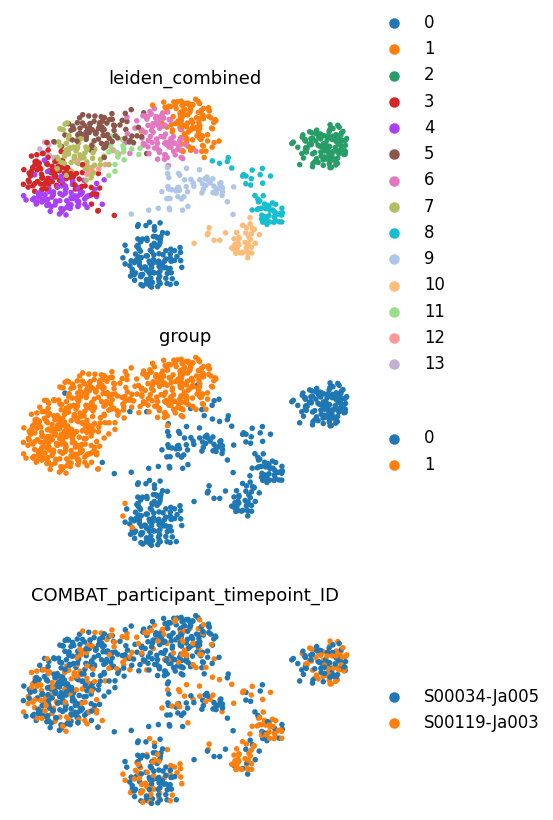

In [27]:
sc.pl.umap(
    combined,
    color=["leiden_combined", "group", batch_key],
    frameon=False,
    ncols=1
)

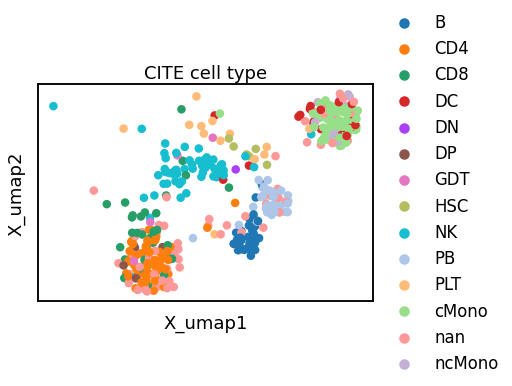

In [28]:
fig = sc.pl.embedding(combined_cite, "X_umap", color=["Annotation_major_subset"], title="CITE cell type",
                      return_fig=True)

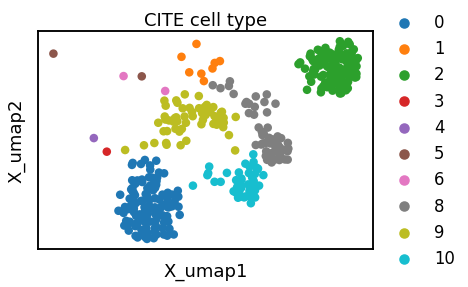

In [29]:
fig = sc.pl.embedding(combined_cite, "X_umap", color=["leiden_combined"], title="CITE cell type",
                      return_fig=True)

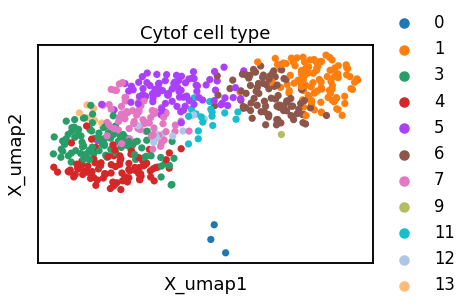

In [30]:
fig = sc.pl.embedding(adata_cytof, "X_umap", color=["leiden_combined"], title="Cytof cell type",
                      return_fig=True)

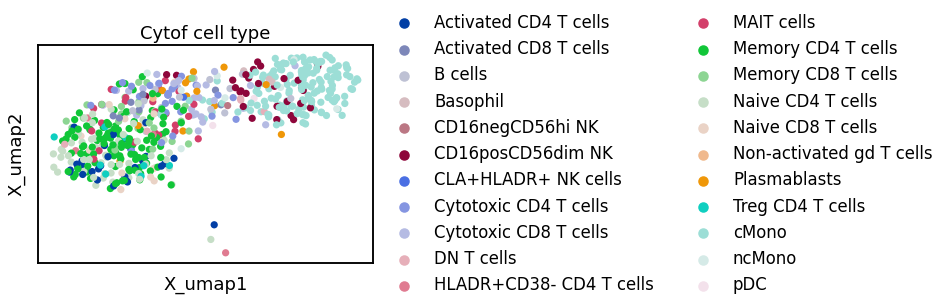

In [31]:
fig = sc.pl.embedding(adata_cytof, "X_umap", color=["major_cell_type"], title="Cytof cell type",
                      return_fig=True)

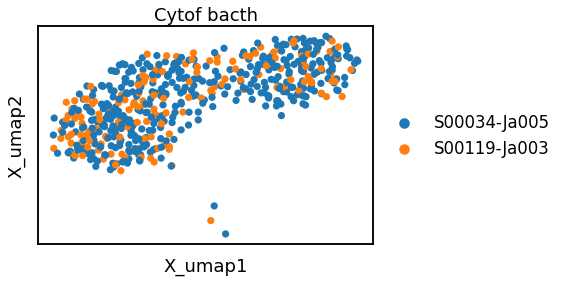

In [32]:
fig = sc.pl.embedding(adata_cytof, "X_umap", color=[batch_key], title="Cytof bacth",
                      return_fig=True)

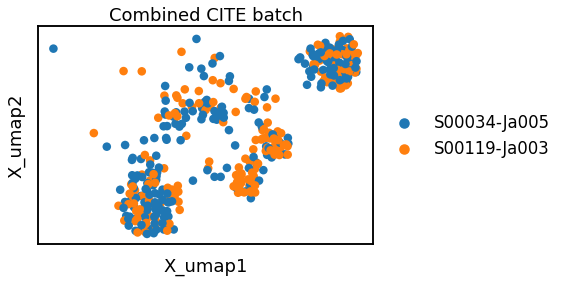

In [33]:
fig = sc.pl.embedding(combined_cite, "X_umap", color=[batch_key], title="Combined CITE batch",
                      return_fig=True)